In [135]:
using Plots
using NPZ
using SCYFI
using GTF
using LinearAlgebra
using MultivariateStats
using Arblib
using Combinatorics

In [132]:

function generate_bitflip_k(bitvector, k)
    M = length(bitvector)
    bitflip_k_versions = []
    mutable_bitvector = copy(bitvector)  # Create a mutable copy
    for indices in combinations(1:M, k)
        for i in indices
            mutable_bitvector[i] = !mutable_bitvector[i]
        end
        push!(bitflip_k_versions, copy(mutable_bitvector))  # Push a copy of the modified bitvector
        for i in indices  # Reset the modified bits back to original values
            mutable_bitvector[i] = !mutable_bitvector[i]
        end
    end
    return bitflip_k_versions
end


"""
ALRNN
"""
function get_latent_time_series_backwards(time_steps:: Integer, A:: Array, W:: Array, h:: Array, dz::Integer, num_relus::Integer; z_0:: Array= nothing,  D_pool::Any = [], traj=nothing, correction_T=nothing)
    if z_0 === nothing
        z = transpose(randn(1,dz))
    else
        z = z_0
    end
    trajectory = Array{Array}(undef, time_steps)
    trajectory[1] = z_0
    for t = 2:time_steps
        z,D_pool = latent_step_backwards(z, A, W, h, num_relus, D_pool)
        if z === nothing
            return trajectory[1:t-1],D_pool
        end
        #return if value out of interesting regime
        if any(abs.(z) .> 100000)
            return trajectory[1:t-1],D_pool
        end
        trajectory[t] = z
    end
    return trajectory,D_pool
end

"""
ALRNN step
"""
function latent_step_backwards(z:: Array, A:: Array, W:: Array, h::Array,num_relus::Integer, D_pool::Any)
    dims = size(A)[1]
    D = Diagonal(vcat(ones(dims-num_relus),z[end-(num_relus-1):end].>0))
    z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
    z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
    if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
        D_int= parse(Int, join(diag(Bool.(D)) .|> (x -> x ? "1" : "0")), base=2)
        if D_int ∈ D_pool
            return z_candidate,D_pool
        else
            push!(D_pool,D_int)
            return z_candidate,D_pool
        end
    else
        D = Diagonal(vcat(ones(dims-num_relus),z_candidate[end-(num_relus-1):end].>0))
        z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
        z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
        if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
            D_int= parse(Int, join(diag(Bool.(D)) .|> (x -> x ? "1" : "0")), base=2)
            if D_int ∈ D_pool
                return z_candidate,D_pool
            else
                push!(D_pool,D_int)
                return z_candidate,D_pool
            end	
        else
            #println("Test previously visited regions")
            for D_int in D_pool
                D = Diagonal(convert(Array{Bool},collect(bitstring(D_int)[length(bitstring(D_int))-dims+1:end]).=='1'))
                z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
                z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
                if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
                    return z_candidate,D_pool
                end
            end
            #println("entered combinatorics mode")
            D = Bool.(Diagonal(vcat(ones(dims-num_relus),z[end-(num_relus-1):end].>0)))
            for k=1:num_relus
               # println("Testing all flips of order $k")
                D_versions=generate_bitflip_k(diag(D)[end-(num_relus-1):end], k)
                for Ds in D_versions#0:0.1:50
                    D_=Diagonal(vcat(ones(dims-num_relus),Ds))
                    try
                        z_candidate =BigFloat.(Arblib.inv(A+W*D_)*(z-h))
                        z_forward=latent_step_old(z_candidate, A, W, h,num_relus)
                    catch ex 
                        if isa(ex,SingularException)
                            continue
                        else 
                            return error(ex)
                        end
                    end

                    if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
                        D_int= parse(Int, join(Bool.(diag(D_)) .|> (x -> x ? "1" : "0")), base=2)
                        if D_int ∈ D_pool
                            return z_candidate,D_pool
                        else
                            push!(D_pool,D_int)
                            return z_candidate,D_pool
                        end                        
                    end
                end
            end
            println(z)
            println(round.(Float64.(z),sigdigits=2))
            #println(z_candidate)
            println(round.(Float64.(z_forward),sigdigits=2))
            return nothing,D_pool #error("HEURISTIC FAILED YOU NEED TO FIND A DIFFERENT SOLUTION")
        end
   
    end
end

function euclidean_distance(p1, p2)
    return sqrt(sum((p1 .- p2) .^ 2))
end
"""
ALRNN step
"""
function latent_step_old(z:: Array, A:: Array, W:: Array, h::Array,num_relus)
    return A*z + W* vcat(z[1:end-num_relus,:], max.(0,z)[end-(num_relus-1):end,:]) + h
end


latent_step_old

In [35]:
data=npzread("C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI//Figures/Figure4/example cell/ExampleCell/lukas_data.npy")
#model_path = "C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI/Results/Example_cell_MAE_Condreg1e-5_4_noise_3/Empirical-M_ALRNN-O_Identity-T_100-clip_10.0-τ_10-M_15-relu_6-L2reg_0.3/003/checkpoints"#workes for cyscle
#model_path = "C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI/Results/Example_cell_Condreg1e-5_4_noise/Empirical-M_ALRNN-O_Identity-T_100-clip_10.0-τ_10-M_15-relu_6-L2reg_0.3/003/checkpoints" #model 1650 
model_path = "C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI/Results/Example_cell_Condreg1e-5_4_noise/Empirical-M_ALRNN-O_Identity-T_100-clip_10.0-τ_10-M_15-relu_6-L2reg_0.3/020/checkpoints" #model 1800
m, O = load_model(model_path*"/model_"*"1800"*".bson")
traj=generate(m,O,data[10,1:end],10000000)

10000000×6 Matrix{Float64}:
 -0.284151   -0.406783   -0.090522   -0.451963   -0.361603   -0.0647047
 -0.0462769  -0.113974   -0.0583527  -0.0596016  -0.151462   -0.0121403
  0.0291909  -0.794589    0.516164   -0.0579442  -0.476734    0.170712
  0.0184657  -0.61565     0.830123   -0.0424324  -0.414519    0.398058
 -0.0569976  -0.326162    0.78454    -0.108597   -0.254834    0.426519
 -0.141142   -0.257405    0.876625   -0.203352   -0.0962876   0.472925
 -0.154526   -0.225505    1.14952    -0.219061   -0.0545017   0.648212
 -0.152497   -0.241254    1.334      -0.204629   -0.096301    0.795424
 -0.203531   -0.230443    1.22011    -0.232457   -0.103653    0.769052
 -0.310554   -0.117124    0.866856   -0.287353   -0.0256698   0.596319
  ⋮                                                           ⋮
 -0.477369   -0.391059   -0.208621   -0.393572   -0.418376    0.156328
 -0.499304   -0.412284    0.107779   -0.367156   -0.433019    0.375289
 -0.4864     -0.436042    0.560039   -0.347035   -0.43

38


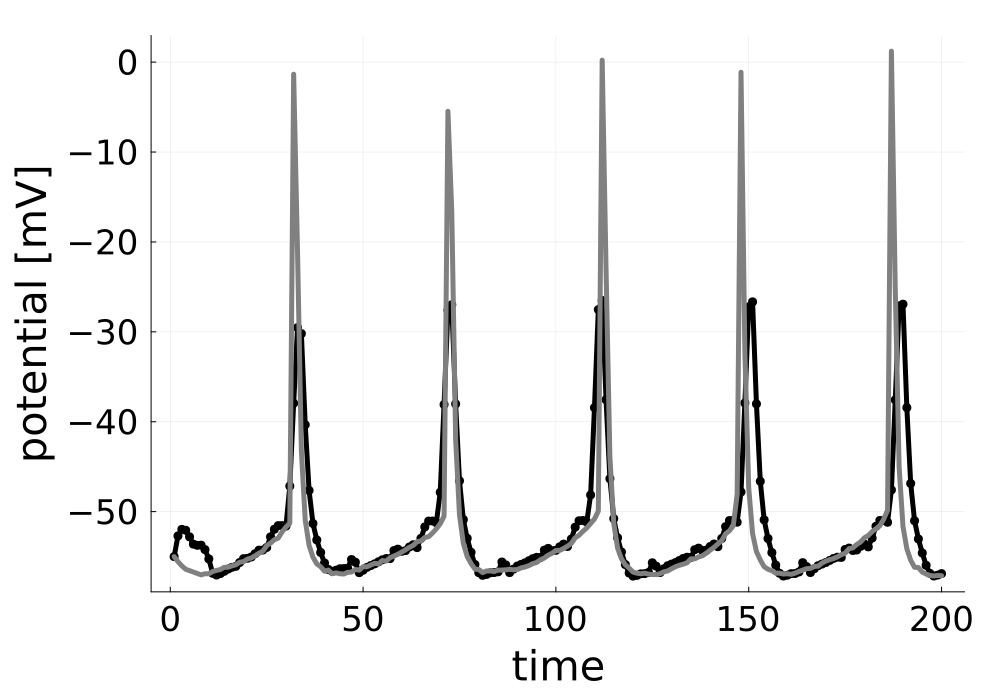

In [36]:
unique_points = unique(round.(traj[9999500:end,1],digits=3),dims=1)
println(length(unique_points))
mean = -0.05224843587548712
std = 0.00968304068272246

#smaller markersA
kl=plot([1:200],(traj[1:200,1].*std.+mean).*1000,markersize=5,label="generated",size=(1000,700),xtickfont=font(23), 
ytickfont=font(23),xguidefontsize=28,yguidefontsize=28,legendfont=font(22),linewidth=5,margin=7Plots.mm,color="black",legend=false,marker=:circle)
plot!([1:200],(data[10:209,1].*std.+mean).*1000,label="data",color="gray",linewidth=5)
xlabel!("time")
ylabel!("potential [mV]")




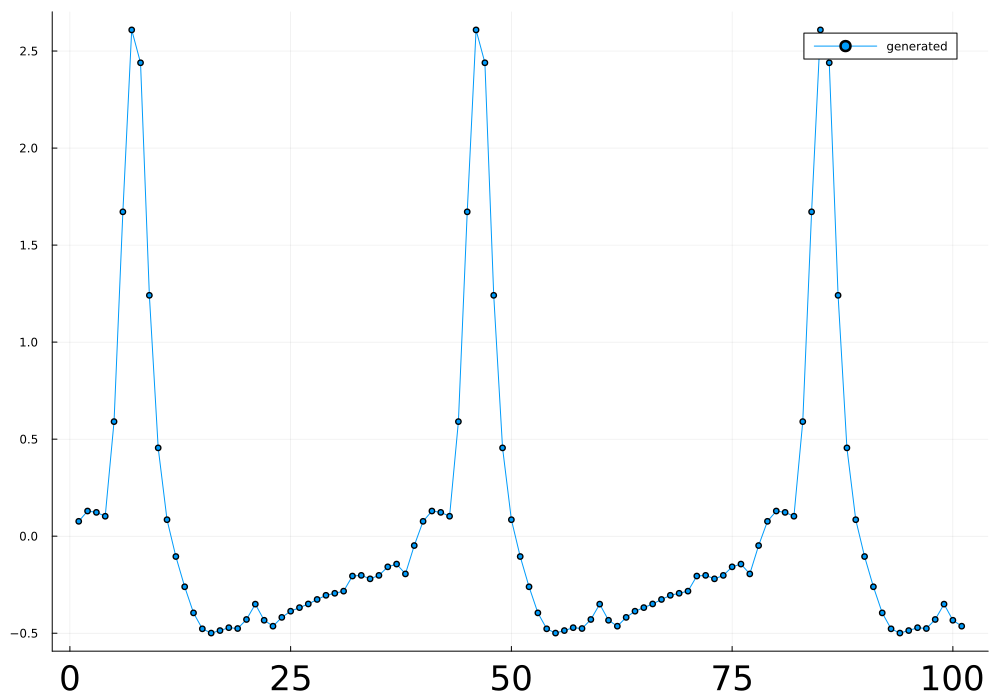

In [37]:
plot(traj[9999900:end,1],markersize=3,marker=:circle,label="generated",size=(1000,700),xtickfont=font(23))

In [124]:
A=diagm(m.A)
W=m.W
h=m.h
num_relus=m.n
dims = size(A)[1]

15

In [39]:
res=find_cycles(A,W,h,num_relus,1,outer_loop_iterations=400,inner_loop_iterations=1000,)

cpu version


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[-0.15908985, 0.0556464, -0.09813191, 0.00075609516, 0.25980568, -0.13518295, -0.23279218, -0.38465962, -0.0055553117, -0.097768724, 0.0019202338, -0.68687624, -0.30460292, 0.5012249, 0.5675605]], Array[Float32[-0.20173742, 0.2212763, -0.18696737, -0.036460675, 0.36662295, -0.18166083, -0.44154918, -0.5081214, 0.095310315, 0.12835763, -0.6735798, -1.362425, -0.46198386, 0.52704036, 0.46472192]], Array[Float32[-0.15737201, -0.14830919, 0.085505, -0.01361327, 0.1652656, -0.021136321, -0.048202842, -0.3535783, -0.17671005, -0.33032236, 0.011657724, 0.13348505, -0.24436446, 0.34732622, 0.5936724]]]]
 [Array[ComplexF32[0.051772013f0 - 0.5665266f0im, 0.051772013f0 + 0.5665266f0im, 0.24656758f0 - 0.31713417f0im, 0.24656758f0 + 0.31713417f0im, 0.31882286f0 + 0.0f0im, 0.3394636f0 - 0.6261883f0im, 0.3394636f0 + 0.6261883f0im, 0.40019822f0 + 0.0f0im, 0.43892926f0 + 0.0f0im, 0.44299895f0 + 0.0f0im, 0.5924174f0 + 0.0f0im, 0.8277639f0 + 0.0f0im, 

In [40]:
println(length(res[2][1]))
for i=1:length(res[2][1])
    println(all.(abs.(res[2][1][i]).<1))
    println(all(abs.(res[2][1][i]).<1))
end


3
Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
false
Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
true
Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
false


In [11]:
#res=find_cycles(A,W,h,num_relus,[1,39,40],outer_loop_iterations=5000,inner_loop_iterations=5000,PLRNN=SCYFI.ALRNN())


cpu version


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[0.11649009, -0.16853245, -0.30049473, 0.17893712, -0.1782103, -0.2990857, -0.17946461, -0.21477531, -0.20773347, 0.3814065, 0.16345195, 0.1608581, 0.023629554, -0.19808231, 0.18446496]], Array[Float32[0.0990037, -0.6349637, -0.41393846, 0.18219459, -0.6047759, -0.31922945, 0.6957567, -0.2777895, 0.22360262, 0.46849138, 0.60551566, -2.0567253, 0.7606903, 0.05156006, 1.6066536]], Array[Float32[0.06528273, -0.59328306, -0.39654195, 0.14302559, -0.56623673, -0.30965284, 0.60439986, -0.3172676, 0.1446518, 0.40436015, 0.57547444, -1.8297485, 0.7240586, -0.02591609, 1.4690576]]], Array[Array[Float32[-0.3118853, 0.14027385, -0.4375802, -0.30038238, 0.133977, -0.43855956, -0.99988896, -0.1594232, 1.2224352, -2.1621952, -6.7349477, 3.3336601, -9.039332, -3.429527, -2.036068], Float32[-0.29366243, 0.32350737, -0.44743717, -0.2807451, 0.28602144, -0.44351828, -0.46027315, 0.5166961, 1.8193624, -1.3031697, -6.714823, 2.5638304, -9.111094, -2.05

In [45]:
res2=find_cycles(A,W,h,num_relus,39,outer_loop_iterations=500,inner_loop_iterations=500,PLRNN=SCYFI.ALRNN())


cpu version


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[-0.15737201, -0.14830919, 0.085505, -0.01361327, 0.1652656, -0.021136321, -0.048202842, -0.3535783, -0.17671005, -0.33032236, 0.011657724, 0.13348505, -0.24436446, 0.34732622, 0.5936724]], Array[Float32[-0.15908985, 0.0556464, -0.09813191, 0.00075609516, 0.25980568, -0.13518295, -0.23279218, -0.38465962, -0.0055553117, -0.097768724, 0.0019202338, -0.68687624, -0.30460292, 0.5012249, 0.5675605]], Array[Float32[-0.20173742, 0.2212763, -0.18696737, -0.036460675, 0.36662295, -0.18166083, -0.44154918, -0.5081214, 0.095310315, 0.12835763, -0.6735798, -1.362425, -0.46198386, 0.52704036, 0.46472192]]], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[]  …  Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[], Array[Array[Float32[-0.14372392, -0.08833025, -0.38972026, -0.19302846, -0.1571925, -0.3346883, -1.4296842, -0.9051992, 0.8837368, 1.5111669, -6.432158, -6.1259966, -0.33105686, 

In [44]:
abs.(res2[2][2][2])



15-element Vector{Float32}:
 1.8866251f-7
 2.5758777f-7
 2.5758777f-7
 2.2968297f-8
 5.2655658f-9
 5.2655658f-9
 1.88409f-8
 1.88409f-8
 6.235797f-8
 1.3118598f-7
 1.5808013f-5
 0.00011504575
 0.0012441945
 0.3798126
 0.53198576

In [47]:
using JSON
function complex_to_dict(z::Complex)
    return Dict("real" => real(z),"imag" => imag(z))
end
# Function to process arrays recursively
function process_array(arr)
    return map(arr) do x
        if x isa Array
            process_array(x)
        elseif x isa Complex
            complex_to_dict(x)
        else
            x
        end
    end
end

# Create the data structure to save
data = Dict(
    "cycles" => process_array(res2)
)

# Save to JSON file
open(model_path*"dynamical_objects_until_39.json", "w") do f
    JSON.print(f, data, 4)  # The 4 argument adds pretty printing with indentation
end

In [85]:
points = Vector[]
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                push!(points,res2[1][i][j][k])
                #end
            end
         end
    catch
        continue
    end
end
#M = fit(PCA, transpose(mapreduce(permutedims, vcat, points)); maxoutdim=2)

In [105]:
M = fit(PCA, transpose(mapreduce(permutedims, vcat, points)); maxoutdim=3)

PCA(indim = 15, outdim = 3, principalratio = 0.9681578)

Pattern matrix (unstandardized loadings):
──────────────────────────────────────
           PC1         PC2         PC3
──────────────────────────────────────
1    0.31269    -0.0200998  -0.371057
2   -0.0645236  -0.498171    0.327184
3   -0.12108     0.445763    0.0879473
4    0.30606    -0.012971   -0.41373
5   -0.113003   -0.454273    0.185477
6   -0.0820519   0.417121    0.112285
7    0.23312     2.99705     0.45688
8    4.46477     0.215746    0.029498
9    3.46725    -0.682551    0.451138
10   2.71541    -0.982901    0.54693
11   5.9577     -0.15631    -1.81004
12  -3.4576      4.29749    -0.691247
13   4.8316      2.19732     0.67844
14   3.05776    -0.200656    0.310429
15   3.51796     2.60829     0.336418
──────────────────────────────────────

Importance of components:
───────────────────────────────────────────────────────────
                                  PC1        PC2        PC3
────────────────────────────────

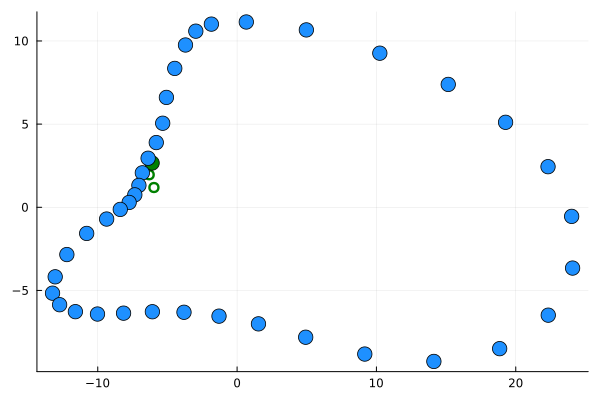

In [149]:
plo=plot()
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                if i==39
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m=8,color="dodgerblue",markershape=:circle,label=nothing)
                    #else
                    #    scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m = (5, :white, stroke(3, "dodgerblue")),markershape=:circle,label=nothing)
                    end
                elseif i==1    
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m=8,color="green",markershape=:circle,label=nothing)
                    else
                        scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m = (5, :white, stroke(3, "green")),markershape=:circle,label=nothing)
                    end
                end
            end
         end
    catch
        continue
    end
end
display(plo)

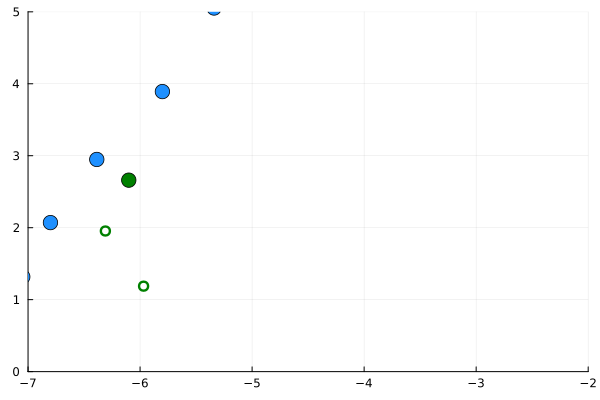

In [150]:
plo_zoom =plo

xlims!(plo_zoom,(-7,-2))
ylims!(plo_zoom,(0,5))

display(plo_zoom)

In [119]:
abs.(res2[2][1][3]).<1

15-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [151]:
D_pool=[]
plotted_points = []
min_distance = 0.1
det(Diagonal(A))
#for k =1:length(res[1][1])
#D=Diagonal((W_2 *res[1][1][1][1] +h_2) .> 0)
id=1
D=Diagonal(vcat(ones(dims-num_relus),res2[1][1][id][1][end-(num_relus-1):end].>0))
e = (A + W * D) 
F=eigen(e) 
idx_stable=findall(abs.(F.values) .< 1)
idx_unstable=findall(abs.(F.values) .> 1)
#plo=plot(f)
for idx_s in idx_stable
    D_pool=[]
    println(idx_s)
    for i=1:100
        #println(i)
        #try
        for factor=[0.01,0.1]
            z_start = res2[1][1][id][1] + real(F.vectors[:,idx_s]).* (rand() * 2 - 1) * factor
            #try
            traj_,D_pool = get_latent_time_series_backwards(50, Matrix(Diagonal(A)), W, h, 2, num_relus; z_0= BigFloat.(z_start),D_pool)
            traj=mapreduce(permutedims,vcat,traj_)            #println(size(traj))
        #only plot points where now value exceeds 7
            filtered_traj = Float64.(traj[vec(all(abs.(traj) .<= 1000, dims=2)), :])
        #println(size(filtered_traj))
        #println(filtered_traj[:,1])
            for j in 1:size(filtered_traj, 1)
                point = filtered_traj[j, :]
                if all(euclidean_distance(point, plotted_point) > min_distance for plotted_point in plotted_points)
                    push!(plotted_points, point)
                    #scatter!(plo, [point[1]], [point[2]], [point[3]], color = "black", marker = (3))
                    scatter!(plo,[predict(M,point)[1]], [predict(M,point)[2]], color = "black", marker = (3),label=nothing)
                end
            end         #catch
                #    continue
            #end
        end
    end
end


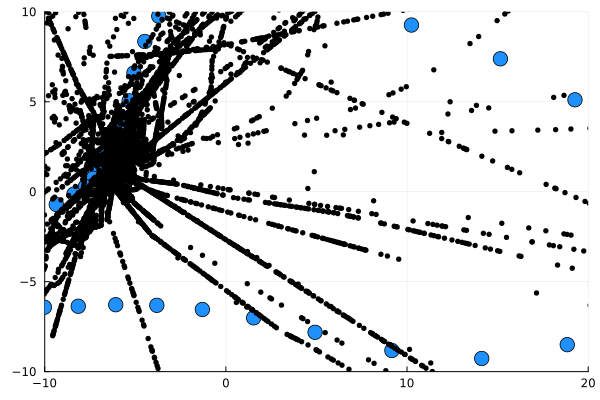

In [152]:
xlims!(plo,(-10,20))
ylims!(plo,(-10,10))
display(plo)

## Plot w/o PCA

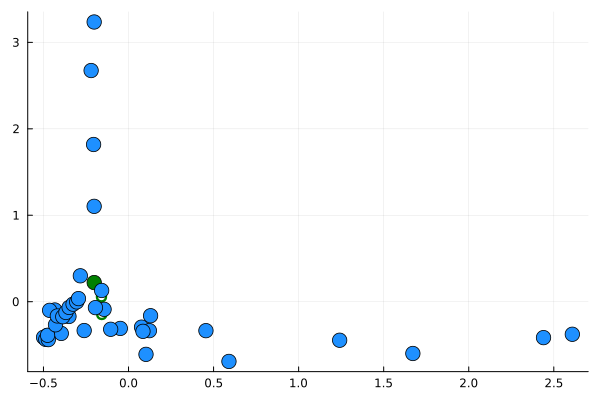

In [153]:
plo=plot()
for i in eachindex(res2[1])
    #println(length(res2[1][i]))
    try
        for j in eachindex(res2[1][i])
           for k = 1:length(res2[1][i][j])
                #for n =1:j
                println(res2[1][i][j])
                if i==39
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[res2[1][i][j][k][1]], [res2[1][i][j][k][2]],m=8,color="dodgerblue",markershape=:circle,label=nothing)
                    #else
                    #    scatter!(plo,[predict(M,res2[1][i][j][k])[1]], [predict(M,res2[1][i][j][k])[2]],m = (5, :white, stroke(3, "dodgerblue")),markershape=:circle,label=nothing)
                    end
                elseif i==1    
                    if all(abs.(res2[2][i][j]).<1)
                        scatter!(plo,[res2[1][i][j][k][1]], [res2[1][i][j][k][2]],m=8,color="green",markershape=:circle,label=nothing)
                    else
                        scatter!(plo,[res2[1][i][j][k][1]], [res2[1][i][j][k][2]],m = (5, :white, stroke(3, "green")),markershape=:circle,label=nothing)
                    end
                end
            end
         end
    catch
        continue
    end
end
display(plo)

In [154]:
D_pool=[]
plotted_points = []
min_distance = 0.1
det(Diagonal(A))
#for k =1:length(res[1][1])
#D=Diagonal((W_2 *res[1][1][1][1] +h_2) .> 0)
id=1
D=Diagonal(vcat(ones(dims-num_relus),res2[1][1][id][1][end-(num_relus-1):end].>0))
e = (A + W * D) 
F=eigen(e) 
idx_stable=findall(abs.(F.values) .< 1)
idx_unstable=findall(abs.(F.values) .> 1)
#plo=plot(f)
for idx_s in idx_stable
    D_pool=[]
    println(idx_s)
    for i=1:100
        #println(i)
        #try
        for factor=[0.01,0.1]
            z_start = res2[1][1][id][1] + real(F.vectors[:,idx_s]).* (rand() * 2 - 1) * factor
            #try
            traj_,D_pool = get_latent_time_series_backwards(10, Matrix(Diagonal(A)), W, h, 2, num_relus; z_0= BigFloat.(z_start),D_pool)
            traj=mapreduce(permutedims,vcat,traj_)            #println(size(traj))
        #only plot points where now value exceeds 7
            filtered_traj = Float64.(traj[vec(all(abs.(traj) .<= 1000, dims=2)), :])
        #println(size(filtered_traj))
        #println(filtered_traj[:,1])
            for j in 1:size(filtered_traj, 1)
                point = filtered_traj[j, :]
                if all(euclidean_distance(point, plotted_point) > min_distance for plotted_point in plotted_points)
                    push!(plotted_points, point)
                    #scatter!(plo, [point[1]], [point[2]], [point[3]], color = "black", marker = (3))
                    scatter!(plo,[point[1]], [point[2]], color = "black", marker = (3),label=nothing)
                end
            end         #catch
                #    continue
            #end
        end
    end
end


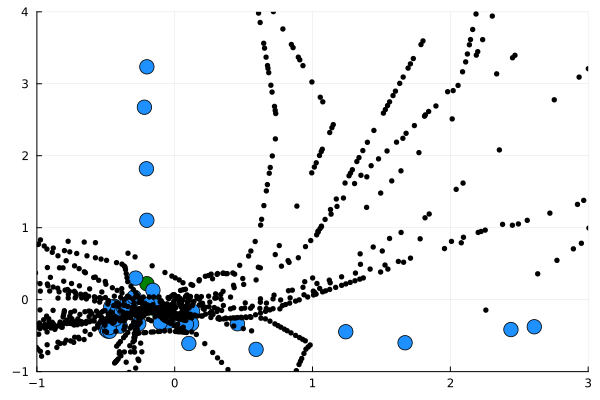

In [156]:
xlims!(plo,(-1,3))
ylims!(plo,(-1,4))
display(plo)